In [ ]:
import numpy as np 
import os
import cv2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Creating Model:**

In [ ]:
def create_model(input_shape, pool_size):
    # Create the actual neural network here
    model = Sequential()
    # Normalizes incoming inputs. First layer needs the input shape to work
    model.add(BatchNormalization(input_shape=input_shape))

    # Below layers were re-named for easier reading of model summary; this not necessary
    # Conv Layer 1
    model.add(Conv2D(8, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv1'))

    # Conv Layer 2
    model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv2'))

    # Pooling 1
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 3
    model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv3'))
    model.add(Dropout(0.2))

    # Conv Layer 4
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv4'))
    model.add(Dropout(0.2))

    # Conv Layer 5
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv5'))
    model.add(Dropout(0.2))

    # Pooling 2
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 6
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv6'))
    model.add(Dropout(0.2))

    # Conv Layer 7
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv7'))
    model.add(Dropout(0.2))

    # Pooling 3
    model.add(MaxPooling2D(pool_size=pool_size))

    # Upsample 1
    model.add(UpSampling2D(size=pool_size))

    # Deconv 1
    model.add(Conv2DTranspose(64, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv1'))
    model.add(Dropout(0.2))

    # Deconv 2
    model.add(Conv2DTranspose(64, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv2'))
    model.add(Dropout(0.2))

    # Upsample 2
    model.add(UpSampling2D(size=pool_size))

    # Deconv 3
    model.add(Conv2DTranspose(32, (3, 3), padding='same' , strides=(1,1), activation = 'relu', name = 'Deconv3'))
    model.add(Dropout(0.2))

    # Deconv 4
    model.add(Conv2DTranspose(32, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv4'))
    model.add(Dropout(0.2))

    # Deconv 5
    model.add(Conv2DTranspose(16, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv5'))
    model.add(Dropout(0.2))

    # Upsample 3
    model.add(UpSampling2D(size=pool_size))

    # Deconv 6
    model.add(Conv2DTranspose(16, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv6'))

    # Final layer - only including one channel so 1 filter
    model.add(Conv2DTranspose(1, (3, 3), padding='same', strides=(1,1), activation = 'sigmoid', name = 'Final'))

    return model

**Extracting frames from input video:**

In [ ]:
def getFrames(filename):
    video = cv2.VideoCapture(filename)
    fps = video.get(cv2.CAP_PROP_FPS)
    i = 0.
    col_images = []
    frame_times = []

    while video.isOpened():
        ret, frame = video.read()
        if ret:
            new_h=256
            new_w=256
            resize = cv2.resize(frame, (new_w, new_h),0)
            col_images.append(resize)
            frame_times.append(i)
            i += 0.05
            video.set(1, round(i * fps))
        else:
            video.release()
            break
    return col_images
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
imgs_train = getFrames('/content/drive/MyDrive/drive3.mp4')
# imgs_mask_train = getFrames('/content/drive/MyDrive/Vid1Output.mp4')
imgs_mask_train = getFrames('/content/drive/MyDrive/filledPolygon.mp4')

imgs_train = np.array(imgs_train)
imgs_mask_train = np.array(imgs_mask_train)

In [ ]:
imgs_mask_train.shape

(613, 256, 256, 3)

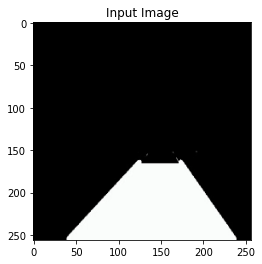

In [ ]:
plt.imshow(imgs_mask_train[10])
plt.title("Input Image")
plt.show()

**Training Data:**

In [ ]:
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization
imgs_train -= mean
imgs_train /= std

In [ ]:
imgs_mask_train=np.dot(imgs_mask_train[...,:3], [0.299, 0.587, 0.114])

In [ ]:
imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255

In [ ]:
imgs_mask_train.shape

(613, 256, 256)

In [ ]:
imgs_mask_train=imgs_mask_train.reshape(613,256, 256, 1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(imgs_train, imgs_mask_train)

Skip the part below if the model was already saved: 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(imgs_train, imgs_mask_train)

# Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
batch_size = 10
epochs = 10
pool_size = (2, 2)
input_shape = X_train.shape[1:]

# Create the neural network
model = create_model(input_shape, pool_size)

# Compiling and training the model
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs, verbose=1,shuffle=True, validation_data=(X_val, y_val))

# Save model architecture and weights
model.save('full_CNN_model.h5')

# Show summary of model
model.summary()

Epoch 1/10
46/46 [==============================] - 213s 5s/step - loss: 0.3894 - accuracy: 0.8131 - val_loss: 0.1994 - val_accuracy: 0.8156
Epoch 2/10
46/46 [==============================] - 209s 5s/step - loss: 0.1881 - accuracy: 0.7954 - val_loss: 0.1828 - val_accuracy: 0.7595
Epoch 3/10
46/46 [==============================] - 217s 5s/step - loss: 0.1745 - accuracy: 0.7707 - val_loss: 0.1650 - val_accuracy: 0.7835
Epoch 4/10
46/46 [==============================] - 209s 5s/step - loss: 0.1596 - accuracy: 0.7871 - val_loss: 0.1537 - val_accuracy: 0.7884
Epoch 5/10
46/46 [==============================] - 210s 5s/step - loss: 0.1502 - accuracy: 0.7894 - val_loss: 0.1512 - val_accuracy: 0.7886
Epoch 6/10
46/46 [==============================] - 210s 5s/step - loss: 0.1435 - accuracy: 0.7917 - val_loss: 0.1418 - val_accuracy: 0.7912
Epoch 7/10
46/46 [==============================] - 211s 5s/step - loss: 0.1378 - accuracy: 0.7937 - val_loss: 0.1366 - val_accuracy: 0.7929
Epoch 8/10
46

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("modelf.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelf.h5")
print("Saved model to disk")

Saved model to disk


**Load model file:**

In [ ]:
# load json and create model
json_file = open('modelOld.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelOld.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# loaded_model.trainable= False
loaded_model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
loaded_model.summary()

In [ ]:
imgs_test = imgs_train
print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
imgs_mask_test = loaded_model.predict(imgs_test, verbose=1)

******************************
Predicting masks on test data...
******************************
20/20 [==============================] - 70s 3s/step


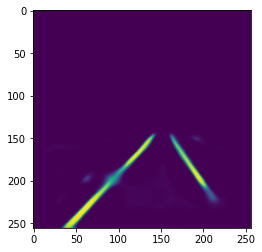

In [ ]:
plt.imshow(imgs_mask_test[7][...,0])
plt.show()

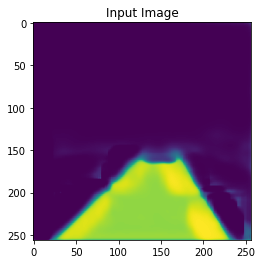

In [ ]:
src2= imgs_mask_test[7][...,0]
plt.imshow(src2)
plt.title("Input Image")
plt.show()

**Creating final output video on the test set:**

In [ ]:
# for a clearer output:
imgs_mask_test[imgs_mask_test>0.5]=1
imgs_mask_test[imgs_mask_test<0.5]=0

In [ ]:
# output shape should modified to allow for using it in addweighted cv function:
imgs_mask_test1=np.repeat(imgs_mask_test.reshape(613,256, 256, 1), 3, axis=3)

In [ ]:
pred_dir = 'pre6'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)

for i in range(len(imgs_mask_test)):
    s1=imgs_test[i]*std+ mean
    s2=imgs_mask_test1[i]*255
    s2[np.where((s2==[255,255,255]).all(axis=2))] = [0,0,255]
    dst = cv2.addWeighted(s1.astype(np.uint8), 1, s2.astype(np.uint8), 1, 0)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '.png'), dst)

In [ ]:
# input frames path
pathIn= '/content/pre6/'

# output path to save the video
pathOut = 'LaneDetectionSingleLines.mp4'

# specify frames per second
fps = 20.0

In [ ]:
from os.path import isfile, join
import re

# get file names of the frames
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

In [ ]:
frame_list = []
from tqdm.notebook import tqdm as tqdm_notebook
for i in tqdm_notebook(range(len(files))):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_list.append(img)

In [ ]:
# write the video
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
        out.write(frame_list[i])

out.release()